https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d

In [30]:
import librosa
audio_path = 'audio-path/D1_S1.wav'
x , sr = librosa.load(audio_path)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [31]:
librosa.load(audio_path, sr=44100)
#librosa.load(audio_path, sr=none)
import IPython.display as ipd
ipd.Audio(audio_path)

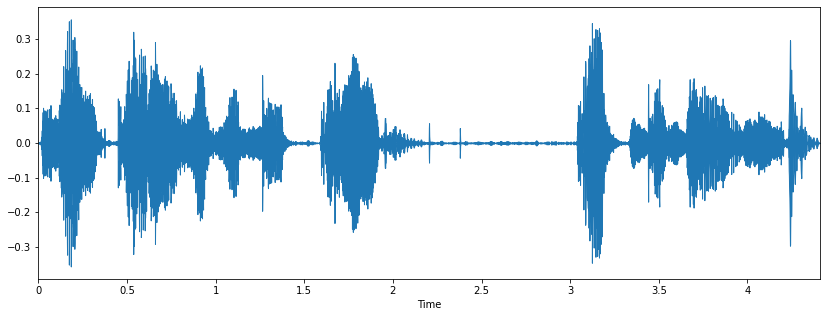

In [32]:
#display waveform
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

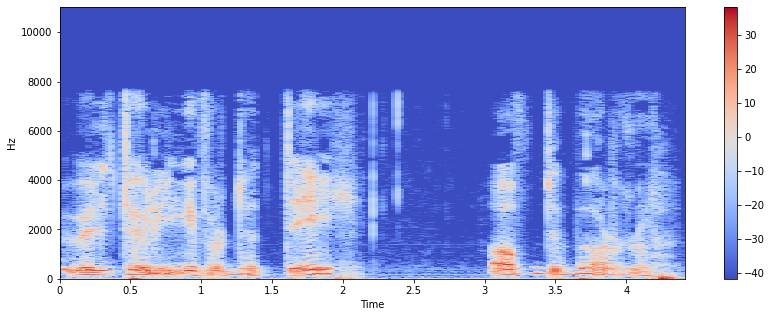

In [33]:
#display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

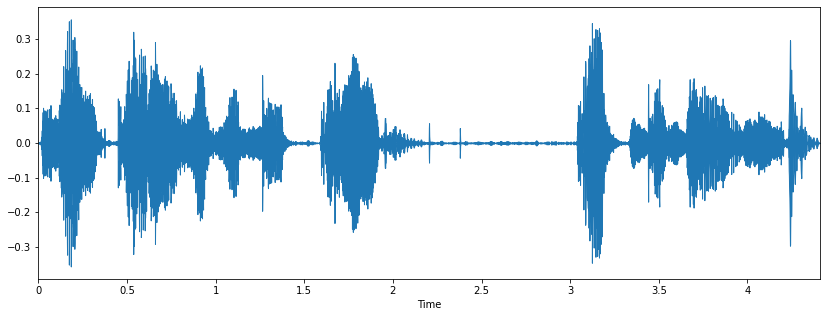

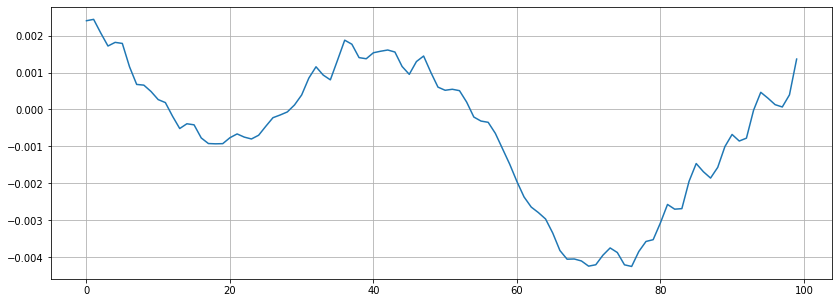

In [34]:
x, sr = librosa.load(audio_path)
#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

In [35]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

4


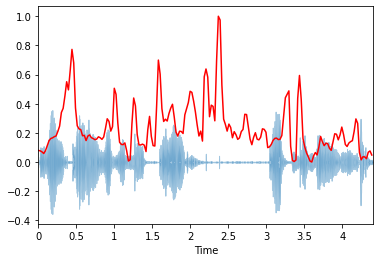

In [36]:
#spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

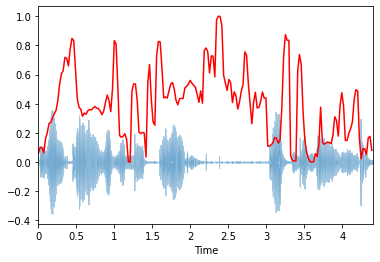

In [37]:
spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

(20, 190)


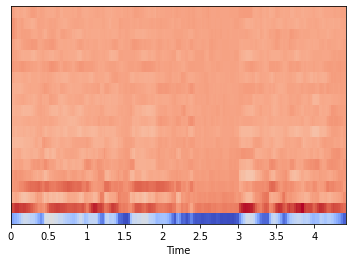

In [38]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [39]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
#Keras
import keras

In [40]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [42]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'dysartrie hearingimpairmant laryng normal'.split()
for g in genres:
    for filename in os.listdir(f'./genres/{g}'):
        songname = f'./genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rmse(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [43]:
data = pd.read_csv('data.csv')
data.head()
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)
data.head()
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
print(y)
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [44]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128)

Epoch 1/20
1/1 [==============================] - 0s 1ms/step - loss: 2.3253 - accuracy: 0.3061
Epoch 2/20
1/1 [==============================] - 0s 1ms/step - loss: 2.1718 - accuracy: 0.3061
Epoch 3/20
1/1 [==============================] - 0s 2ms/step - loss: 2.0396 - accuracy: 0.3673
Epoch 4/20
1/1 [==============================] - 0s 1ms/step - loss: 1.9208 - accuracy: 0.4082
Epoch 5/20
1/1 [==============================] - 0s 2ms/step - loss: 1.8083 - accuracy: 0.4898
Epoch 6/20
1/1 [==============================] - 0s 1ms/step - loss: 1.6981 - accuracy: 0.5306
Epoch 7/20
1/1 [==============================] - 0s 3ms/step - loss: 1.5900 - accuracy: 0.5918
Epoch 8/20
1/1 [==============================] - 0s 2ms/step - loss: 1.4826 - accuracy: 0.6327
Epoch 9/20
1/1 [==============================] - 0s 2ms/step - loss: 1.3775 - accuracy: 0.6531
Epoch 10/20
1/1 [==============================] - 0s 3ms/step - loss: 1.2758 - accuracy: 0.6735
Epoch 11/20
1/1 [======================

In [46]:
test_loss, test_acc = model.evaluate(X_test,y_test)
print('test_acc: ',test_acc)

1/1 [==============================] - 0s 4ms/step - loss: 1.0612 - accuracy: 0.5385
test_acc:  0.5384615659713745
